In [ ]:
# Something tells me that using stateful=True in my problem,
# is actually not the right approach. 
# , 
# (Reading through the section "LSTM with Memory Between Batches" 
#    in https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 
# I'm picking up that stateful=True benefits learning really long sequences,
# I guess that go beyond the length of the "look back" denoted by 
# the input_shape )
#
# That being said, the 256 size I happen to have chosen was somewhat arbitrarily
# based on the 256 Hz sampling rate of all the physiological sensors in the experiment.
# 
# I don't know if 1 second is a long enough chunk of the pattern, but I think yes,
# because visually observing , back in https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-06-08-visually-inspect-generated-sequences.md ,
# the slope can be picked up. Hmm but that being said, 
# the data in quesetion is sthe respiration. Maybe for heart rate 1 second is enough,
# but perhaps for respiration, maybe a sequence needs to capture a period or a 
# period and a half or two?
#
# Anyway, LSTMs have memory in between the individual LSTM cell units (and so
# to me it makes sense that using 64 units like I am, in principle should cover
# a full 64 seconds of respiration in this case. At least that's what I'm rationalizing
# that is happening. ) 
#
# That being said, maybe I really do need to "force forget" in between the four
# different classes I have examples for.

In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())



True


In [6]:
# tf.losses?? # l   tf.keras.layers.Dense
# hinge_loss
# huber_loss
# log_loss
# mean_pairwise_squared_error
# mean_squared_error
# sigmoid_cross_entropy
# softmax_cross_entropy
# sparse_softmax_cross_entropy

# Also, I have been using no activation function in my tf.keras.layers.Dense() final layer,
# this implicitly is a pass-through, `a(x) = x` basically.
# - One alternative is activation='sigmoid' , for a (0,1) 
#
# (But reading https://stats.stackexchange.com/questions/282842/dealing-with-sparse-categories-in-binary-cross-entropy , 
#  I get the impression that if the loss function also computes sigmoid then the advice is 
#  to leave the Dense        activation as linear. 
#  However, the classification example  at https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/ , 
#    does also use activation=sigmoid with a loss=binary_cross entropy. Although
#    Jason's example is just two classes (binary up/down ) whereas the stackoverflow
#    example is more like my case with more than 2 classes.

# My case is mutually exclusive however . At least that's the intent in the 
#    problem description. 

# ...
# reading about these again... 
# (1) https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits , 
# "Measures the probability error in discrete classification tasks in 
#   which each class is independent and not mutually exclusive. 
#   For instance, one could perform multilabel classification where a picture can contain 
#   both an elephant and a dog at the same time."
#
#
#
# (2) https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits 
#
# , """Measures the probability error in discrete classification tasks in which the classes are mutually exclusive 
#    (each entry is in exactly one class).
#
#    NOTE: While the classes are mutually exclusive, their probabilities need not be. All that is required is that each row of labels is a valid probability distribution. 
#     If they are not, the computation of the gradient will be incorrect.
# 
#   If using exclusive labels (wherein one and only one class is true at a time), 
#     see sparse_softmax_cross_entropy_with_logits."""
#
#
#  ** Umm that sounds like a contradiction actually. (Actually after reading (3),
#       I think I get what they mean)
#
# (3) https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits
#  """Measures the probability error in discrete classification tasks 
#    in which the classes are mutually exclusive (each entry is in exactly one class). 
#    For example, each CIFAR-10 image is labeled with one and only one label: 
#      an image can be a dog or a truck, but not both.
# 
#    NOTE: For this operation, the probability of a given label is considered exclusive. 
#      That is, soft classes are not allowed, and the labels vector 
#      must provide a single specific index for the true class for each row of logits 
#     (each minibatch entry). For soft softmax classification with a probability distribution 
#      for each entry, see softmax_cross_entropy_with_logits_v2. """

In [ ]:
# Okay after re-reading the above (1), (2), (3) descriptions I am on the correct 
#  loss function. I have labels which are not probability distributions, 
#  but instead specific indexes. 
# And my case has mutually exclusive classes unlike the fuzzy case (1).
#
# So I must be doing something else wrong then.

In [ ]:
# Got to try the balancing act one more time,
#  (read through https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
#   also , for more idea coverage.)
# 
# Also shuffle is apparently good idea. 

In [8]:
foo_vec = [np.array([[0,3], [8,3]]), np.array([[12, 3], [77,2]])]
np.concatenate(foo_vec)

array([[ 0,  3],
       [ 8,  3],
       [12,  3],
       [77,  2]])

In [37]:
import math
def get_partitions(vec, slice_size):
    assert slice_size > 0
    #assert isinstance(vec, list)
    num_slices = int(math.floor(len(vec)/slice_size))
    print('num slices', num_slices)
    size_remainder = len(vec) - num_slices*slice_size
    assert size_remainder >= 0
    print('size_remainder, ', size_remainder)
    slices = [vec[k*slice_size:k*slice_size+slice_size] for k in range(num_slices)]
    print('slices, ', slices)
    if size_remainder:
        slices.append(vec[-(size_remainder):])

    return slices

np.concatenate([[1,2], [3,4]])


array([1, 2, 3, 4])

In [39]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'rb') as fd:
    minidata = pickle.load(fd)

In [42]:
reload(mu)
#Hand-tuned ... 
class_weights = {0: 0.1, 1: 0.5, 2: 0.1, 3: 0.3}

training_indices = np.arange(0, minidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

dataset_batches = mu.build_dataset_weighty_v2(minidata, training_indices, class_weights,
        batch_size=1000)


training indices... (47000,)
num slices 47
size_remainder,  0
Counter({3: 404, 0: 221, 2: 207, 1: 168})
weights_per_class,  tf.Tensor([0.00045249 0.00297619 0.00048309 0.00074257], shape=(4,), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
Counter({3: 422, 2: 219, 0: 206, 1: 153})
weights_per_class,  tf.Tensor([0.00048544 0.00326797 0.00045662 0.0007109 ], shape=(4,), dtype=float32)
tf.Tensor(1.0000038, shape=(), dtype=float32)
Counter({3: 410, 2: 226, 0: 207, 1: 157})
weights_per_class,  tf.Tensor([0.00048309 0.00318471 0.00044248 0.00073171], shape=(4,), dtype=float32)
tf.Tensor(1.0000046, shape=(), dtype=float32)
Counter({3: 417, 2: 222, 0: 198, 1: 163})
weights_per_class,  tf.Tensor([0.00050505 0.00306748 0.00045045 0.00071942], shape=(4,), dtype=float32)
tf.Tensor(0.99999934, shape=(), dtype=float32)
Counter({3: 428, 2: 227, 0: 177, 1: 168})
weights_per_class,  tf.Tensor([0.00056497 0.00297619 0.00044053 0.00070093], shape=(4,), dtype=float32)
tf.Tensor(1.0000033, sh

tf.Tensor(1.0000051, shape=(), dtype=float32)
Counter({3: 395, 0: 221, 2: 217, 1: 167})
weights_per_class,  tf.Tensor([0.00045249 0.00299401 0.00046083 0.00075949], shape=(4,), dtype=float32)
tf.Tensor(0.9999964, shape=(), dtype=float32)
Counter({3: 407, 0: 236, 2: 206, 1: 151})
weights_per_class,  tf.Tensor([0.00042373 0.00331126 0.00048544 0.0007371 ], shape=(4,), dtype=float32)
tf.Tensor(0.9999947, shape=(), dtype=float32)
Counter({3: 413, 2: 215, 0: 208, 1: 164})
weights_per_class,  tf.Tensor([0.00048077 0.00304878 0.00046512 0.00072639], shape=(4,), dtype=float32)
tf.Tensor(1.0000006, shape=(), dtype=float32)
Counter({3: 373, 2: 230, 0: 221, 1: 176})
weights_per_class,  tf.Tensor([0.00045249 0.00284091 0.00043478 0.00080429], shape=(4,), dtype=float32)
tf.Tensor(1.0000046, shape=(), dtype=float32)


In [50]:
# okay... now try use that ..
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 256, 1), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [51]:



%time loss_history = mu.do_train(model, dataset_batches)


Instructions for updating:
Use tf.cast instead.
CPU times: user 5min 30s, sys: 2min 29s, total: 7min 59s
Wall time: 5min 7s


Text(0, 0.5, 'Loss [entropy]')

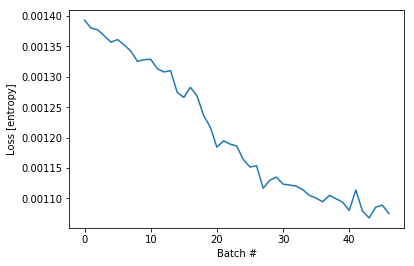

In [52]:
# Loss still pretty small. but Since this is the first time I shuffled, 
# the loss history looks really much more interesting.
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [53]:
print(minidata['x_train'].shape)
train_subset = np.random.choice(np.arange(0, minidata['x_train'].shape[0], 1),
                               10000, replace=False)
print('subset, ', len(train_subset))

# First make sure this random training subset covers all four classes.
Counter(np.argmax(minidata['y_train'][train_subset, :], axis=1))

(47689, 256, 1)
subset,  10000


Counter({3: 4194, 1: 1585, 0: 2171, 2: 2050})

In [54]:
 
%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset], dtype=tf.float32))

# Confusion matrix.

CPU times: user 29.1 s, sys: 10.1 s, total: 39.3 s
Wall time: 11.3 s


In [55]:
# confusion... 
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor: id=4349858, shape=(4, 4), dtype=int32, numpy=
array([[   0, 2171,    0,    0],
       [   0, 1585,    0,    0],
       [   0, 2050,    0,    0],
       [   0, 4194,    0,    0]], dtype=int32)>